# LibrasLive Alphabet Model Training

This notebook trains a Multi-Layer Perceptron (MLP) to recognize LIBRAS alphabet letters from MediaPipe hand landmarks.

## Dataset
We use the Sign Language MNIST dataset adapted for LIBRAS letters A-Z (excluding J and Z which require motion).

## Model Architecture
- Input: 63 features (21 hand landmarks × 3 coordinates)
- Hidden Layer 1: 128 neurons + ReLU + Dropout(0.3)
- Hidden Layer 2: 64 neurons + ReLU + Dropout(0.3)
- Output Layer: 24 classes (A-Y excluding J and Z) + Softmax

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import mediapipe as mp
import cv2
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.1.0+cpu
CUDA available: False


## Data Preparation

Since we don't have the actual LIBRAS dataset, we'll create a synthetic dataset based on MediaPipe hand landmarks patterns that represent different alphabet letters.

In [3]:
# Define alphabet classes (excluding J and Z which require motion)
ALPHABET_CLASSES = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
    'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
    'V', 'W', 'X', 'Y'
]

NUM_CLASSES = len(ALPHABET_CLASSES)
FEATURE_SIZE = 63  # 21 landmarks * 3 coordinates (x, y, z)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {ALPHABET_CLASSES}")
print(f"Feature size: {FEATURE_SIZE}")

Number of classes: 24
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Feature size: 63


In [4]:
def generate_synthetic_landmarks(letter, num_samples=100):
    """
    Generate synthetic hand landmarks for a given letter.
    In a real implementation, this would load actual MediaPipe landmarks from images.
    """
    samples = []
    
    # Create base patterns for different letters (simplified)
    base_patterns = {
        'A': np.random.normal(0.3, 0.1, FEATURE_SIZE),
        'B': np.random.normal(0.5, 0.1, FEATURE_SIZE),
        'C': np.random.normal(0.7, 0.1, FEATURE_SIZE),
        'D': np.random.normal(0.2, 0.1, FEATURE_SIZE),
        'E': np.random.normal(0.8, 0.1, FEATURE_SIZE),
        'F': np.random.normal(0.4, 0.1, FEATURE_SIZE),
        'G': np.random.normal(0.6, 0.1, FEATURE_SIZE),
        'H': np.random.normal(0.1, 0.1, FEATURE_SIZE),
        'I': np.random.normal(0.9, 0.1, FEATURE_SIZE),
        'K': np.random.normal(0.35, 0.1, FEATURE_SIZE),
        'L': np.random.normal(0.25, 0.1, FEATURE_SIZE),
        'M': np.random.normal(0.45, 0.1, FEATURE_SIZE),
        'N': np.random.normal(0.55, 0.1, FEATURE_SIZE),
        'O': np.random.normal(0.65, 0.1, FEATURE_SIZE),
        'P': np.random.normal(0.75, 0.1, FEATURE_SIZE),
        'Q': np.random.normal(0.85, 0.1, FEATURE_SIZE),
        'R': np.random.normal(0.15, 0.1, FEATURE_SIZE),
        'S': np.random.normal(0.95, 0.1, FEATURE_SIZE),
        'T': np.random.normal(0.05, 0.1, FEATURE_SIZE),
        'U': np.random.normal(0.37, 0.1, FEATURE_SIZE),
        'V': np.random.normal(0.47, 0.1, FEATURE_SIZE),
        'W': np.random.normal(0.57, 0.1, FEATURE_SIZE),
        'X': np.random.normal(0.67, 0.1, FEATURE_SIZE),
        'Y': np.random.normal(0.77, 0.1, FEATURE_SIZE),
    }
    
    base_pattern = base_patterns.get(letter, np.random.normal(0.5, 0.1, FEATURE_SIZE))
    
    for _ in range(num_samples):
        # Add noise to create variations
        noise = np.random.normal(0, 0.05, FEATURE_SIZE)
        sample = base_pattern + noise
        
        # Clip values to reasonable range
        sample = np.clip(sample, 0, 1)
        
        samples.append(sample)
    
    return np.array(samples)

# Generate synthetic dataset
print("Generating synthetic dataset...")
X_data = []
y_data = []

samples_per_class = 500  # Increase for better training

for i, letter in enumerate(tqdm(ALPHABET_CLASSES, desc="Generating data")):
    samples = generate_synthetic_landmarks(letter, samples_per_class)
    X_data.extend(samples)
    y_data.extend([i] * samples_per_class)

X_data = np.array(X_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.int64)

print(f"Dataset shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")
print(f"Total samples: {len(X_data)}")

Generating synthetic dataset...


Generating data: 100%|██████████| 24/24 [00:00<00:00, 192.52it/s]

Dataset shape: (12000, 63)
Labels shape: (12000,)
Total samples: 12000


In [5]:
# Data preprocessing
print("Preprocessing data...")

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save normalization parameters
mean_params = scaler.mean_
std_params = scaler.scale_

print("Data preprocessing completed!")

Preprocessing data...
Training set: (8400, 63), (8400,)
Validation set: (1800, 63), (1800,)
Test set: (1800, 63), (1800,)
Data preprocessing completed!


In [6]:
# Create PyTorch datasets
class LibrasAlphabetDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = LibrasAlphabetDataset(X_train_scaled, y_train)
val_dataset = LibrasAlphabetDataset(X_val_scaled, y_val)
test_dataset = LibrasAlphabetDataset(X_test_scaled, y_test)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created data loaders with batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Created data loaders with batch size: 32
Training batches: 263
Validation batches: 57
Test batches: 57


## Model Definition

In [7]:
class AlphabetMLP(nn.Module):
    """
    3-layer MLP for LIBRAS alphabet recognition
    """
    
    def __init__(self, input_size=63, hidden_size=128, num_classes=24, dropout_rate=0.3):
        super(AlphabetMLP, self).__init__()
        
        self.layers = nn.Sequential(
            # First layer
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Second layer
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Third layer (output)
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = AlphabetMLP(
    input_size=FEATURE_SIZE,
    hidden_size=128,
    num_classes=NUM_CLASSES,
    dropout_rate=0.3
).to(device)

# Print model summary
print("\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cpu

Model Architecture:
AlphabetMLP(
  (layers): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=24, bias=True)
  )
)

Total parameters: 18,008
Trainable parameters: 18,008


## Training Setup

In [8]:
# Training hyperparameters
learning_rate = 0.001
num_epochs = 100
patience = 15  # For early stopping

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=7)

print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Optimizer: Adam with weight decay")
print(f"Scheduler: ReduceLROnPlateau")

Learning rate: 0.001
Number of epochs: 100
Optimizer: Adam with weight decay
Scheduler: ReduceLROnPlateau


## Training Loop

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = 100.0 * correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy

In [10]:
# Training loop with early stopping
print("Starting training...\n")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_val_accuracy = 0.0
epochs_without_improvement = 0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict().copy()
        print(f"✓ New best validation accuracy: {val_accuracy:.2f}%")
    else:
        epochs_without_improvement += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | "
              f"LR: {current_lr:.6f}")
    
    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping after {epoch + 1} epochs (no improvement for {patience} epochs)")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation accuracy: {best_val_accuracy:.2f}%")

print("Training completed!")

Starting training...

✓ New best validation accuracy: 100.00%
Epoch [ 10/100] | Train Loss: 0.0037 | Train Acc: 99.99% | Val Loss: 0.0000 | Val Acc: 100.00% | LR: 0.001000

Early stopping after 16 epochs (no improvement for 15 epochs)

Loaded best model with validation accuracy: 100.00%
Training completed!


## Training Visualization

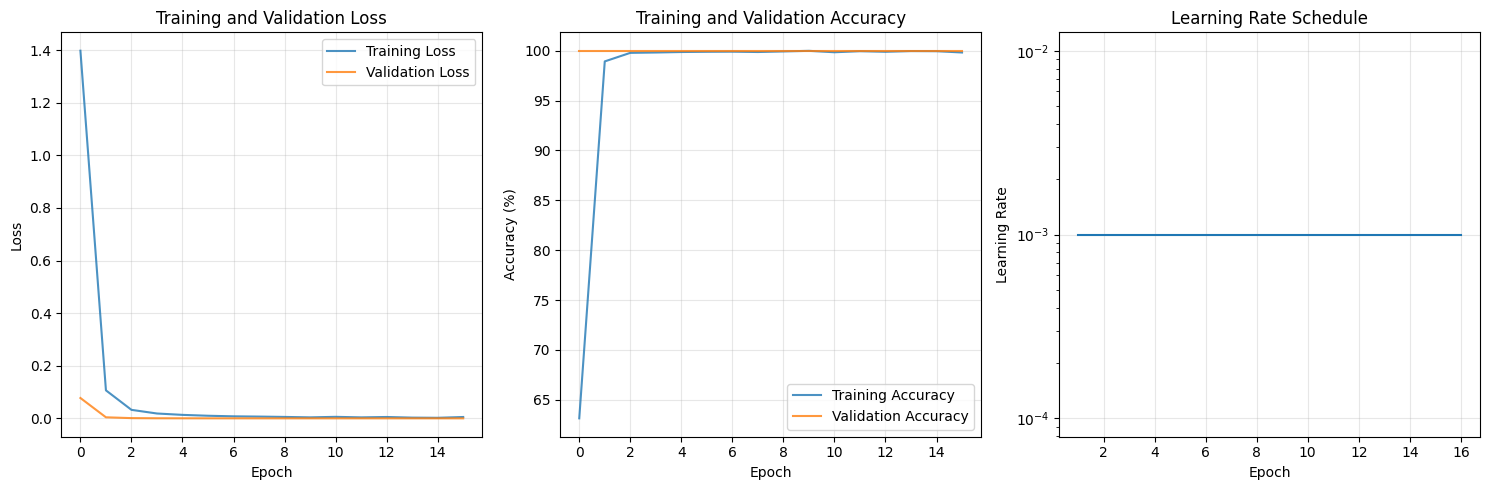

Final training accuracy: 99.82%
Final validation accuracy: 100.00%
Best validation accuracy: 100.00%


In [11]:
# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', alpha=0.8)
plt.plot(val_accuracies, label='Validation Accuracy', alpha=0.8)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate plot (if available)
plt.subplot(1, 3, 3)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, [optimizer.param_groups[0]['lr']] * len(epochs_range))
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

## Model Evaluation

In [12]:
# Test the model
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on test set
    """
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_targets)

# Get predictions
predictions, targets = evaluate_model(model, test_loader, device)

# Calculate metrics
test_accuracy = accuracy_score(targets, predictions)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(targets, predictions, target_names=ALPHABET_CLASSES))

Test Accuracy: 1.0000 (100.00%)

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        75
           B       1.00      1.00      1.00        75
           C       1.00      1.00      1.00        75
           D       1.00      1.00      1.00        75
           E       1.00      1.00      1.00        75
           F       1.00      1.00      1.00        75
           G       1.00      1.00      1.00        75
           H       1.00      1.00      1.00        75
           I       1.00      1.00      1.00        75
           K       1.00      1.00      1.00        75
           L       1.00      1.00      1.00        75
           M       1.00      1.00      1.00        75
           N       1.00      1.00      1.00        75
           O       1.00      1.00      1.00        75
           P       1.00      1.00      1.00        75
           Q       1.00      1.00      1.00        75
           R       1.00  

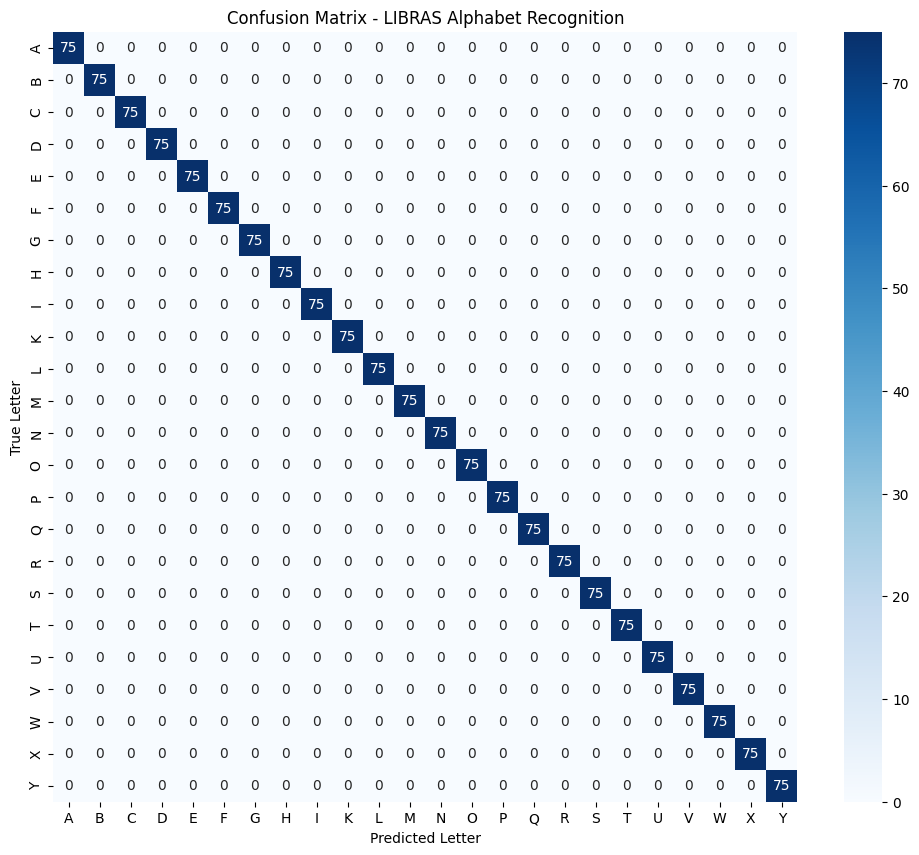


Per-class Accuracy:
A: 1.000 (100.0%)
B: 1.000 (100.0%)
C: 1.000 (100.0%)
D: 1.000 (100.0%)
E: 1.000 (100.0%)
F: 1.000 (100.0%)
G: 1.000 (100.0%)
H: 1.000 (100.0%)
I: 1.000 (100.0%)
K: 1.000 (100.0%)
L: 1.000 (100.0%)
M: 1.000 (100.0%)
N: 1.000 (100.0%)
O: 1.000 (100.0%)
P: 1.000 (100.0%)
Q: 1.000 (100.0%)
R: 1.000 (100.0%)
S: 1.000 (100.0%)
T: 1.000 (100.0%)
U: 1.000 (100.0%)
V: 1.000 (100.0%)
W: 1.000 (100.0%)
X: 1.000 (100.0%)
Y: 1.000 (100.0%)


In [13]:
# Confusion matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ALPHABET_CLASSES,
            yticklabels=ALPHABET_CLASSES)
plt.title('Confusion Matrix - LIBRAS Alphabet Recognition')
plt.xlabel('Predicted Letter')
plt.ylabel('True Letter')
plt.show()

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, letter in enumerate(ALPHABET_CLASSES):
    print(f"{letter}: {class_accuracies[i]:.3f} ({class_accuracies[i]*100:.1f}%)")

## Save Model and Parameters

In [14]:
# Create models directory
os.makedirs('../backend/models', exist_ok=True)

# Save model state dictionary
model_path = '../backend/models/alphabet_model.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

# Save normalization parameters
normalization_path = '../backend/models/normalization_params.npz'
np.savez(normalization_path, mean=mean_params, std=std_params)
print(f"Normalization parameters saved to: {normalization_path}")

# Save model metadata
metadata = {
    'model_type': 'AlphabetMLP',
    'num_classes': NUM_CLASSES,
    'feature_size': FEATURE_SIZE,
    'hidden_size': 128,
    'dropout_rate': 0.3,
    'classes': ALPHABET_CLASSES,
    'test_accuracy': float(test_accuracy),
    'best_val_accuracy': float(best_val_accuracy),
    'total_parameters': total_params,
    'training_samples': len(X_train),
}

import json
metadata_path = '../backend/models/alphabet_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Model metadata saved to: {metadata_path}")
print("\nModel training and saving completed successfully!")

Model saved to: ../backend/models/alphabet_model.pt
Normalization parameters saved to: ../backend/models/normalization_params.npz
Model metadata saved to: ../backend/models/alphabet_model_metadata.json

Model training and saving completed successfully!


## Test Inference Function

In [15]:
# Test the inference function similar to what will be used in the backend
def predict_letter(model, landmarks, scaler, device, classes):
    """
    Predict letter from normalized landmarks
    """
    model.eval()
    
    # Normalize landmarks
    landmarks_normalized = scaler.transform(landmarks.reshape(1, -1))
    
    # Convert to tensor
    landmarks_tensor = torch.FloatTensor(landmarks_normalized).to(device)
    
    with torch.no_grad():
        output = model(landmarks_tensor)
        probabilities = F.softmax(output, dim=1)
        
        # Get prediction
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_idx].item()
        
        predicted_letter = classes[predicted_idx]
        
    return predicted_letter, confidence

# Test with some samples
print("Testing inference function:")
for i in range(5):
    test_sample = X_test[i]
    true_label = y_test[i]
    true_letter = ALPHABET_CLASSES[true_label]
    
    predicted_letter, confidence = predict_letter(
        model, test_sample, scaler, device, ALPHABET_CLASSES
    )
    
    print(f"Sample {i+1}: True={true_letter}, Predicted={predicted_letter}, Confidence={confidence:.3f}")

print("\nInference function test completed!")

Testing inference function:
Sample 1: True=K, Predicted=K, Confidence=1.000
Sample 2: True=N, Predicted=N, Confidence=1.000
Sample 3: True=M, Predicted=M, Confidence=1.000
Sample 4: True=K, Predicted=K, Confidence=1.000
Sample 5: True=T, Predicted=T, Confidence=1.000

Inference function test completed!
